<img src="http://escolar.itam.mx/centro_tesis/img/logo-ITAM.png" style="width:250px">

# <center> Teoría del cerebro y neuroinformática </center>

## <center> Hill climbing </center>

## Objetivos:
Se desea crear un agente con aprendizaje dinámico que logre escalar una colina. Supongamos que existe un robot $R$ en una posición $(x,y)$ del espacio como se muestra en la gráfica siguiente, el espacio simula una colina con un árbol en la cima. El objetivo del agente R es llegar a la cima de la colina. 

### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.mlab import bivariate_normal
from random import randint

### Funciones

In [199]:
#Funcion que regresa la posición para determinadas x,y:
def getPos(x,y):
    return [xc[x,x], yc[y,y],zc[x,y]]

#Función que calcula la distancia euclidiana entre dos puntos:
def dist(a,b):
    xp = (a[0]-b[0])
    yp = (a[1]-b[1])
    zp = (a[2]-b[2])
    d = (xp**2+yp**2+zp**2)**0.5
    return d
#Funcion que regresa la pista olfativa de los cuatro puntos cardinales
def odor(pos):
    N = 1.0/dist(pos, coord[0])
    S = 1.0/dist(pos, coord[1])
    E = 1.0/dist(pos, coord[2])
    O = 1.0/dist(pos, coord[3])
    return np.array([N,S,E,O])
#Función que regresa la recompensa, aumenta cuando se acerca a la meta.
def payoff(pos):
    return 1.0/dist(pos,tree)

#Función que regresa la salida final de la red
def finalOutput(outputs):
    outputs = outputs*1
    if(np.sum(outputs)==4 or np.sum(outputs)==0):
        outputs = np.random.randint(0,2,4)
    if(outputs[0]+outputs[1]==2):
        outputs[0] = np.random.randint(0,2)
        outputs[1] = not outputs[0]
    if(outputs[2]+outputs[3]==2):
        outputs[2] = np.random.randint(0,2)
        outputs[3] = not outputs[2]
    return outputs

def graficaCamino3D(tree,coord, pos, camino):
    #------Gráfica
    fig = plt.figure(figsize = (16,10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(xc, yc, zc, rstride=2, cstride=2, alpha=0.3)
    if(type(camino)==np.ndarray):
        ax.plot(camino[:,0],camino[:,1],camino[:,2], 'ro')#camino
    ax.plot([tree[0]],[tree[1]],[tree[2]], 'go')
    ax.plot(coord[:,0],coord[:,1],coord[:,2], 'yo')
    ax.plot([pos[0]],[pos[1]],[pos[2]], 'bo')
    cset = ax.contour(xc, yc, zc, zdir='z', offset=0, cmap=cm.coolwarm)
    cset = ax.contour(xc, yc, zc, zdir='x', offset=-lim, cmap=cm.coolwarm)
    cset = ax.contour(xc, yc, zc, zdir='y', offset=lim, cmap=cm.coolwarm)
    ax.set_xlabel('Oeste(x)')
    ax.set_ylabel('Sur(y)')
    ax.set_zlabel('Altura(z)')
    plt.show()
    
def graficaCamino2D(tree,coord,pos,camino,i,zs):
    #------Gráfica
    fig = plt.figure(figsize = (16,4))
    plt.subplot(1,2,1)
    plt.title("Camino recorrido")
    if(type(camino)==np.ndarray):
        plt.plot(camino[:,0],camino[:,1], 'ro')#camino
    plt.plot([tree[0]],[tree[1]], 'go')
    plt.plot([pos[0]],[pos[1]], 'bo')
    plt.plot(coord[:,0],coord[:,1], 'yo')
    plt.xlabel('Oeste(x)')
    plt.ylabel('Sur(y)')
    plt.subplot(1,2,2)
    plt.title("Progreso de la recompensa")
    plt.plot(range(0,i),zs[0:i])
    plt.show()
    
#Función que grafica el mapa vectorial en el campo:
def graficaVectores(ws):
    X = np.linspace(-lim, lim, n)
    Y = np.linspace(-lim, lim, n)

    uAux = np.zeros((n,n))
    vAux = np.zeros((n,n))
    sAux = np.zeros(4)
    for i in range(0,n):
        for j in range(0,n):
            pos = getPos(i,j)
            x = odor(pos)
            for k in range(0,4):
                sAux[k] = np.sum(x[k]*ws[k])
            vAux[i][j] = sAux[0]+sAux[1]
            uAux[i][j] = sAux[2]+sAux[3]

    U = uAux
    V = vAux

    plt.figure(figsize = (16,16))
    plt.title("Comportamiento Vectorial")
    M = np.hypot(U, V)
    Q = plt.quiver(X, Y, U, V, M, units='x', pivot='tip', width=0.01,
                   scale=.5)
    plt.scatter(X, Y, color='k', s=5)

    plt.show()
    
#Función que genera un modelo para el robot:
def modeloRobot(c,w,t=1,g=1,rvar=1,threshold=1):
    
    #Máxima cantidad de pasos:
    m = 10000

    #Contantes:
    if (c==0): threshold = 100
    a = aIni
    b = bIni
    i=0

    pos = getPos(a,b)
    zs = np.zeros(m)
    s = np.zeros(4)
    camino = np.zeros((m,3))
    
    while(payoff(pos)<threshold and i<m):
        #Calculando métricas
        x = odor(pos)
        z = payoff(pos)
        #Calcular salidas de la red
        for j in range(0,4):
            s[j] = np.dot(x,w[j])
            
        
        #Agregar ruido a la salida
        noise = np.random.normal(0,rvar,4)
        #Salida de la red
        y = s + noise > 0
        y = finalOutput(y)
        #Nueva posición
        a = a + y[0] - y[1]
        b = b + y[2] - y[3]
        if (a>=n): a=a-1       #Verificar límites
        else:
            if (a<=0): a=a+1
        if (b>=n): b=b-1 
        else: 
            if (b<=0): b=b+1
        pos = getPos(a,b)

        #Nueva recompensa
        zn = payoff(pos)
        #Actualizar pesos
        #print "Vieja w:",w
        #print "c:",c
        #print "zn:",zn
        #print "z:",z
        #print "y:",y
        #print "x:",x
        #print "Avanzó(y):",(y[0] - y[1]) 
        #print "Avanzó(x):",(y[2] - y[3]) 

        for j in range(0,4):
            w[j] = w[j] + c*(zn-z)*y[j]*x[j]
            #print "w",j,":es",w[j]
        #print "Nueva w:",w
        #Guardar posición
        zs[i] = zn
        camino[i] = pos
        i = i + 1


    if(t>0):
        print "Posición final:",pos
        print "Distancia del árbol:",dist(pos,tree)
        print "Pasos necesarios:",i
    if(g>0):
        graficaCamino3D(tree,0.5*coord,pos,camino)
        graficaCamino2D(tree,0.5*coord,pos,camino,i,zs)
    return w,pos,dist(pos,tree),camino,i

### Generar datos del terreno (colina)

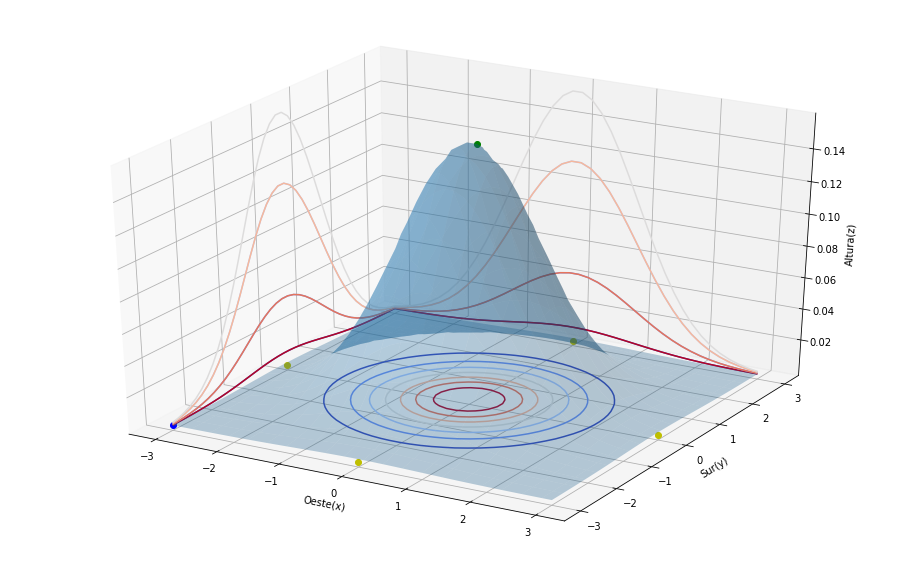

In [205]:
lim = 3
n=40
xc = np.linspace(-lim, lim, n)
yc = np.linspace(-lim, lim, n)
xc, yc = np.meshgrid(xc, yc)
zc = bivariate_normal(xc, yc)

#Posición cordenadas
coord = 2*np.array([[xc[0,0],    0.0        ,zc[0,0]], #norte
                  [xc[n-1,n-1],  0.0        ,zc[0,0]],  #sur
                  [0.0,          yc[n-1,n-1],zc[0,0]],  #este
                  [0.0,          yc[0,0]        ,zc[0,0]]]) #Oeste

#Posición del árbol
tree = getPos(n/2,n/2)

#Posición inicial
a = 0#randint(0, n-1)
b = 0#randint(0, n-1)
pos = getPos(a,b)
aIni = a
bIni = b

#Gráfica terreno inicial:
graficaCamino3D(tree,0.5*coord,pos,0)

### Robot sin aprendizaje, usando simplemente como parámetro el ruido

/home/g/Desktop/ml/env1/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/g/Desktop/ml/env1/lib/python2.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in double_scalars


Posición final: [0.076923076923077094, 0.076923076923077094, 0.15821597860757719]
Distancia del árbol: 0.0
Pasos necesarios: 2228


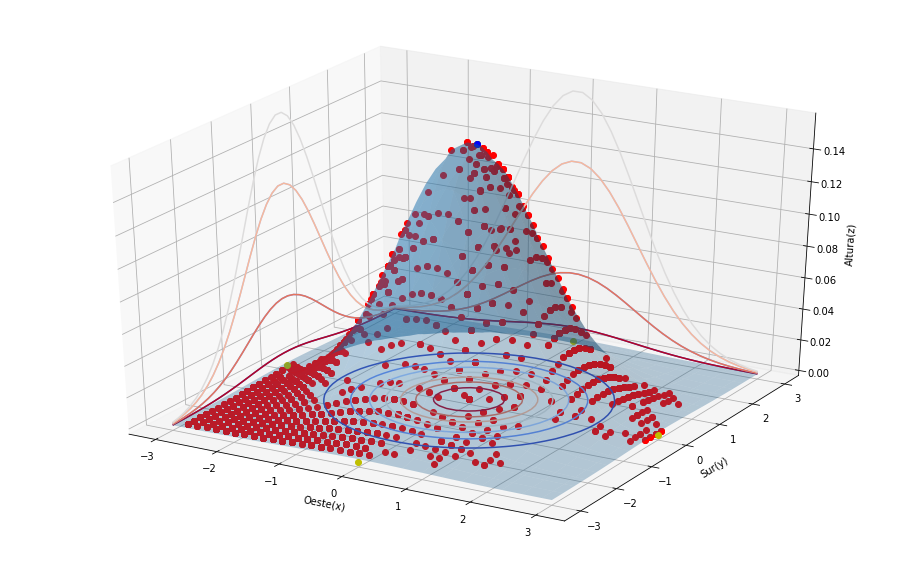

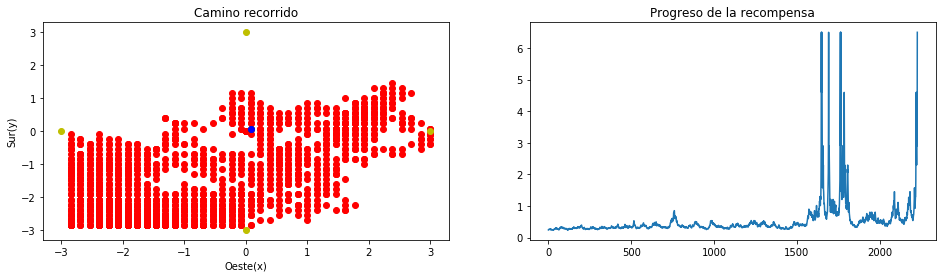

In [206]:
w = np.zeros((4,4))
model = modeloRobot(0.0,w,rvar=10)

### Robot CON aprendizaje, actualizando los pesos de acuerdo al progreso de la recompensa

Posición final: [0.076923076923077094, -0.07692307692307665, 0.15821597860757719]
Distancia del árbol: 0.153846153846
Pasos necesarios: 87


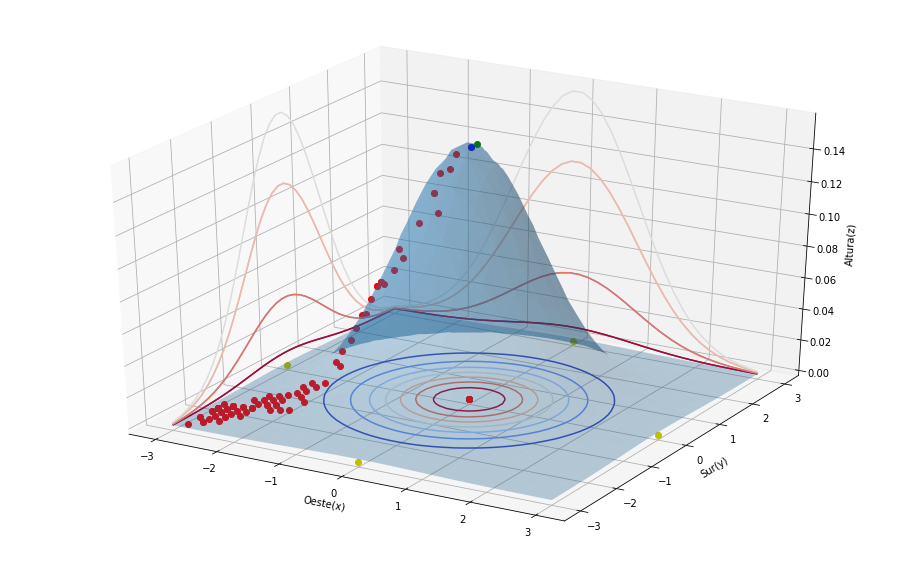

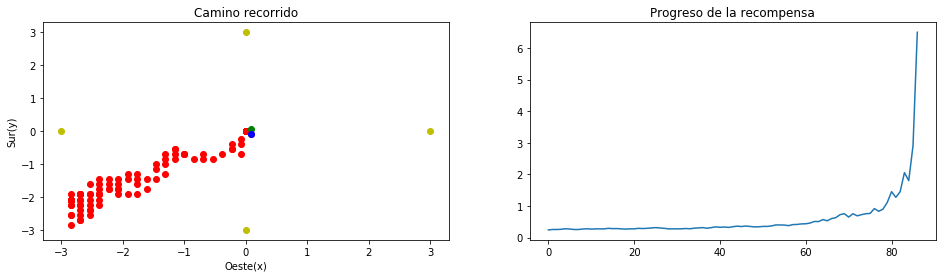

In [207]:
w = np.zeros((4,4))
we,posi,di,caminoi,ii = modeloRobot(0.1,w,rvar=0.01,threshold=3)

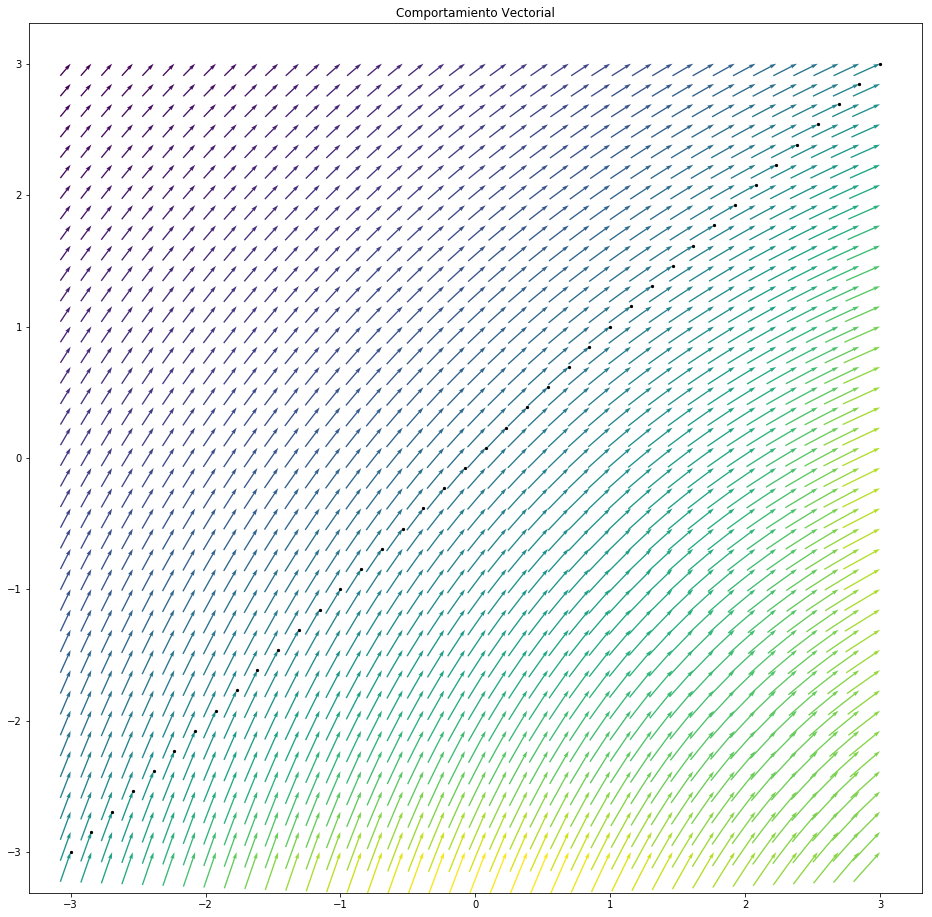

In [208]:
graficaVectores(we)

### Variando la constante de aprendizaje

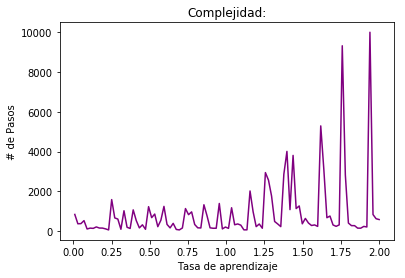

In [225]:
a = 0
nc = 100
npasos = np.zeros(nc)
w = w = np.zeros((4,4))
for c in np.linspace(0.01,2.0,nc):
    #print "Robot con c=%.2f"%(c)
    wi,posi,di,caminoi,ii = modeloRobot(c,w,0,0)
    npasos[a]=ii
    a = a + 1
    #print "-"*100

plt.plot(np.linspace(0.01,2.0,nc),npasos, color="purple")
plt.title("Complejidad:")
plt.ylabel("# de Pasos")
plt.xlabel("Tasa de aprendizaje")
plt.show()

### Conclusiones:
#### Sin aprendizaje
El robot anda por todo el terreno dirijiendo sus movimientos solamente con la influencia del ruido.

#### Durante el aprendizaje
El robot actualiza los pesos en cada iteración aumentando los pesos que producen salidas con mayor recompensa y disminuyendo los que producen salidas más lejanas al árbol.

#### Después del aprendizaje
El mapa de vectores muestra como el robot se debe dirijir hacia el noreste para llegar al árbol.

#### Ruido
El ruido influye mucho ya que si es demasiado grande no permite que el algoritmo tome una decición nunca y si es demasiado pequeño nunca tiene la oportinidad de explorar.

#### Constantes de aprendizaje
parece no haber ninguna relación convexa con la constante de aprendizaje sin embargo, en la gráfica de complejidad se aprecia como entre mayor es la constante le cuesta más llegar a la meta.

#### Bibliografía:
[Quiver plot, matplotlib](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.quiver.html)
<br>
[Landmark learning: An illustration of associative search](https://www.researchgate.net/publication/15873378_Landmark_learning_An_illustration_of_associative_search)